**EDA**

In [31]:
import pandas as pd

# Load the dataset
data = pd.read_csv('Tweets.csv')

# Map the sentiment labels to numerical values
label_mapping = {'negative': 0, 'neutral': 1, 'positive': 2}
data['target'] = df['airline_sentiment'].map(label_mapping)

# Display the distribution of classes
print(data['target'].value_counts())
print(data.head())


target
0    9178
1    3099
2    2363
Name: count, dtype: int64
             tweet_id airline_sentiment  airline_sentiment_confidence  \
0  570306133677760513           neutral                        1.0000   
1  570301130888122368          positive                        0.3486   
2  570301083672813571           neutral                        0.6837   
3  570301031407624196          negative                        1.0000   
4  570300817074462722          negative                        1.0000   

  negativereason  negativereason_confidence         airline  \
0            NaN                        NaN  Virgin America   
1            NaN                     0.0000  Virgin America   
2            NaN                        NaN  Virgin America   
3     Bad Flight                     0.7033  Virgin America   
4     Can't Tell                     1.0000  Virgin America   

  airline_sentiment_gold        name negativereason_gold  retweet_count  \
0                    NaN     cairdin        

In [41]:
total_records = len(df)
sentiment_distribution = df['airline_sentiment'].value_counts()
negative_count = sentiment_distribution.get('negative', 0)
neutral_count = sentiment_distribution.get('neutral', 0)
positive_count = sentiment_distribution.get('positive', 0)

print("\nDataset Overview:")
print(f"Number of records: {total_records}")
print(f"Negative: {negative_count}")
print(f"Neutral: {neutral_count}")
print(f"Positive: {positive_count}")


Dataset Overview:
Number of records: 14640
Negative: 9178
Neutral: 3099
Positive: 2363


<ipython-input-38-965cd6e1ab58>:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.countplot(x='airline_sentiment', data=data, palette='viridis')


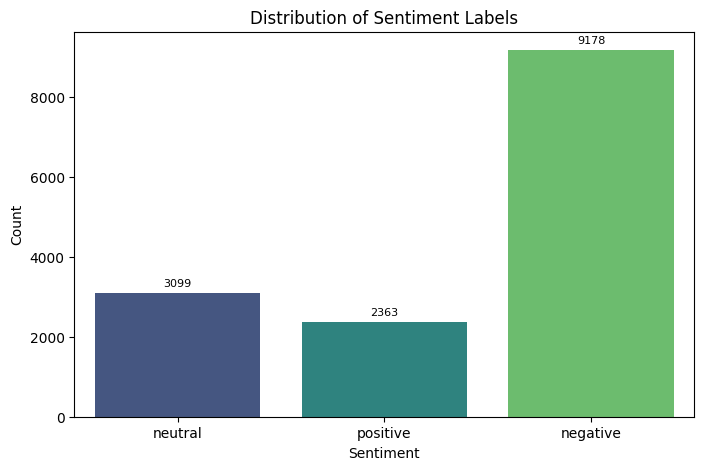

In [38]:
import matplotlib.pyplot as plt
import seaborn as sns

# Count the number of tweets per sentiment class
plt.figure(figsize=(8, 5))
ax = sns.countplot(x='airline_sentiment', data=data, palette='viridis')

# Add counts on top of each bar
for p in ax.patches:
    ax.annotate(f'{int(p.get_height())}',
                (p.get_x() + p.get_width() / 2., p.get_height()),
                ha='center', va='baseline', fontsize=8, color='black', xytext=(0, 5),
                textcoords='offset points')

# Set plot title and labels
plt.title('Distribution of Sentiment Labels')
plt.xlabel('Sentiment')
plt.ylabel('Count')
plt.xticks(rotation=0)
plt.show()


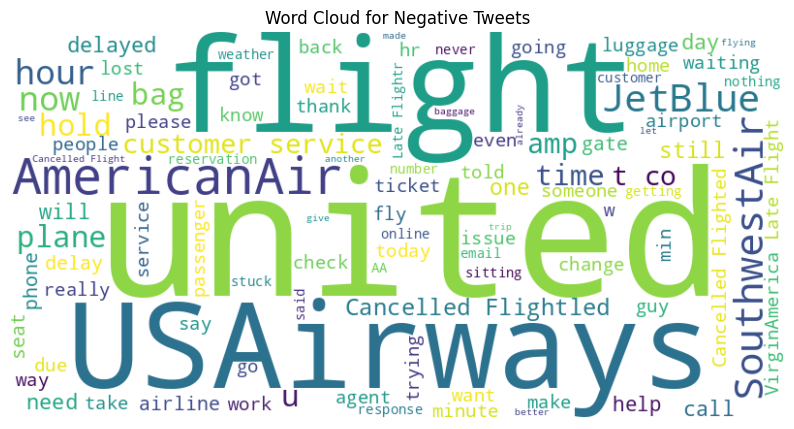

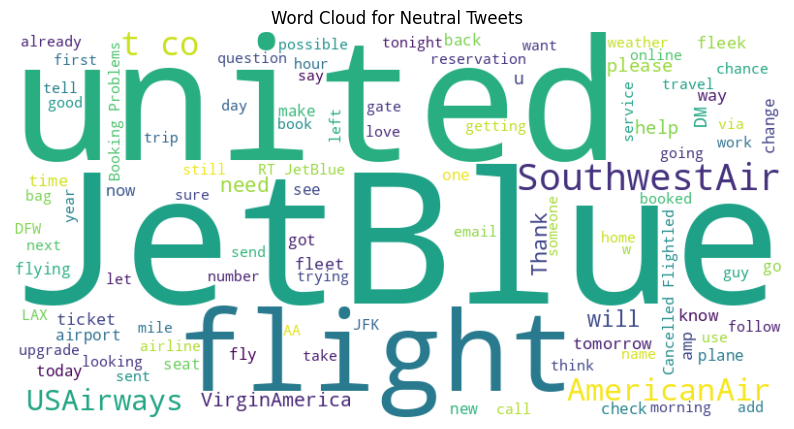

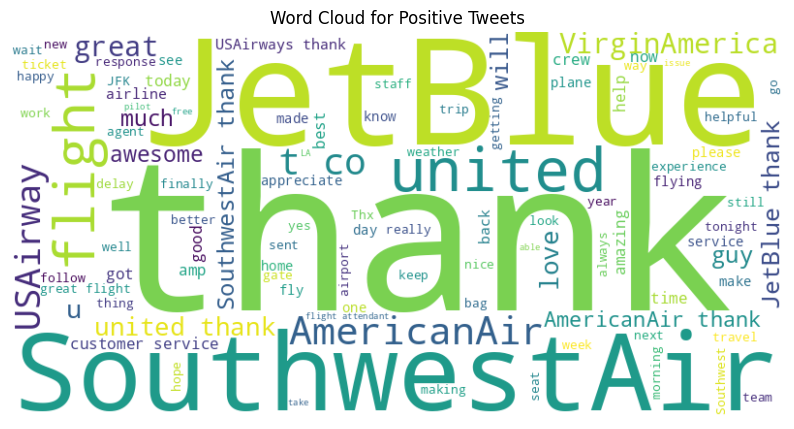

In [33]:
from wordcloud import WordCloud

def generate_wordcloud(sentiment):
    text = " ".join(data[data['airline_sentiment'] == sentiment]['text'])
    wordcloud = WordCloud(width=800, height=400, background_color='white', max_words=100).generate(text)
    plt.figure(figsize=(10, 6))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis('off')
    plt.title(f'Word Cloud for {sentiment.capitalize()} Tweets')
    plt.show()

# Generate word clouds for each sentiment
generate_wordcloud('negative')
generate_wordcloud('neutral')
generate_wordcloud('positive')


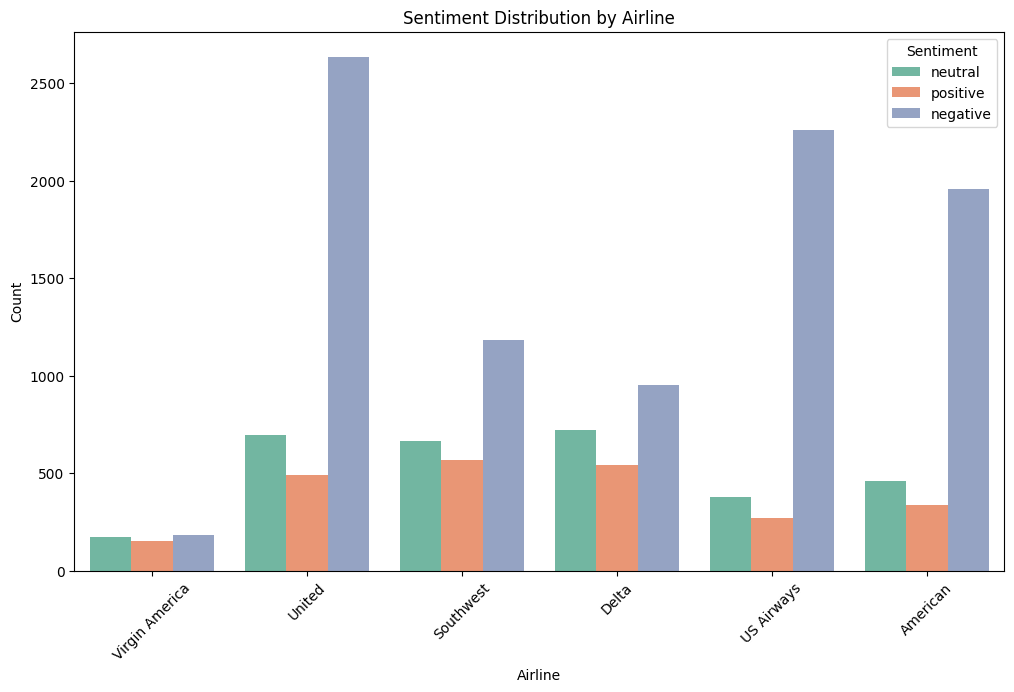

In [34]:
plt.figure(figsize=(12, 7))
sns.countplot(x='airline', hue='airline_sentiment', data=data, palette='Set2')
plt.title('Sentiment Distribution by Airline')
plt.xlabel('Airline')
plt.ylabel('Count')
plt.legend(title='Sentiment')
plt.xticks(rotation=45)
plt.show()


**Data Preprocessing for BERT Modeling**

In [15]:
import pandas as pd

# Load the dataset
df = pd.read_csv('Tweets.csv')

# Keep only the necessary columns
df = df[['text', 'airline_sentiment']]

# Map the sentiment labels to numerical values
label_mapping = {'negative': 0, 'neutral': 1, 'positive': 2}
df['target'] = df['airline_sentiment'].map(label_mapping)

# Display the distribution of classes
print(df['target'].value_counts())
print(df.head())


target
0    9178
1    3099
2    2363
Name: count, dtype: int64
                                                text airline_sentiment  target
0                @VirginAmerica What @dhepburn said.           neutral       1
1  @VirginAmerica plus you've added commercials t...          positive       2
2  @VirginAmerica I didn't today... Must mean I n...           neutral       1
3  @VirginAmerica it's really aggressive to blast...          negative       0
4  @VirginAmerica and it's a really big bad thing...          negative       0


In [16]:
import re

def clean_text(text):
    # Remove URLs
    text = re.sub(r"http\S+|www\S+", "", text)
    # Remove special characters
    text = re.sub(r"[^A-Za-z0-9 ]+", "", text)
    # Convert text to lowercase
    return text.lower()

# Apply the cleaning function to the text column
df['text'] = df['text'].apply(clean_text)


**Data Split in Train and Valid**

In [18]:
from sklearn.model_selection import train_test_split

train_df, val_df = train_test_split(df, test_size=0.3, random_state=42)
print(f"Training size: {len(train_df)}, Validation size: {len(val_df)}")


Training size: 10248, Validation size: 4392


**BERT Tokenizer**

In [19]:
from transformers import BertTokenizer
import torch

# Initialize the BERT tokenizer
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

def encode_data(text_list):
    return tokenizer(
        text_list,
        padding='max_length',
        truncation=True,
        max_length=128,
        return_tensors='pt'
    )

# Encode the training data
train_encodings = encode_data(train_df['text'].tolist())
train_labels = torch.tensor(train_df['target'].tolist())

# Encode the validation data
val_encodings = encode_data(val_df['text'].tolist())
val_labels = torch.tensor(val_df['target'].tolist())


/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


**DataLoader**

In [20]:
from torch.utils.data import Dataset, DataLoader

class SentimentDataset(Dataset):
    def __init__(self, encodings, labels):
        self.encodings = encodings
        self.labels = labels

    def __getitem__(self, idx):
        item = {key: val[idx] for key, val in self.encodings.items()}
        item['labels'] = self.labels[idx]
        return item

    def __len__(self):
        return len(self.labels)

# Create datasets
train_dataset = SentimentDataset(train_encodings, train_labels)
val_dataset = SentimentDataset(val_encodings, val_labels)

# Create DataLoaders
train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True, pin_memory=True)
val_loader = DataLoader(val_dataset, batch_size=16, shuffle=False, pin_memory=True)


**BERT Model for Multi-Class Classification**

In [21]:
from transformers import BertForSequenceClassification, AdamW, get_linear_schedule_with_warmup

# Set up the device (GPU if available)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Load the pre-trained BERT model with num_labels=3 for multi-class classification
model = BertForSequenceClassification.from_pretrained('bert-base-uncased', num_labels=3)
model.to(device)

# Set up the optimizer and learning rate scheduler
optimizer = AdamW(model.parameters(), lr=2e-5)
scheduler = get_linear_schedule_with_warmup(
    optimizer,
    num_warmup_steps=100,
    num_training_steps=len(train_loader) * 3
)


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:591: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


**BERT Model Training**

In [7]:
import torch

# Set the device to GPU if available, otherwise CPU
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Move the model to the device
model.to(device)


BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSdpaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e

**Train BERT Model**

In [22]:
from tqdm import tqdm

epochs = 3
best_val_loss = float('inf')
patience = 2
early_stopping_counter = 0

for epoch in range(epochs):
    # Training phase
    model.train()
    train_loss = 0
    loop = tqdm(train_loader, leave=True)

    for batch in loop:
        inputs = {key: val.to(device) for key, val in batch.items()}

        # Forward pass
        outputs = model(**inputs)
        loss = outputs.loss
        loss.backward()
        optimizer.step()
        scheduler.step()
        optimizer.zero_grad()

        train_loss += loss.item()
        loop.set_description(f'Epoch {epoch + 1}')
        loop.set_postfix(loss=loss.item())

    avg_train_loss = train_loss / len(train_loader)
    print(f"Average Training Loss: {avg_train_loss:.4f}")

    # Validation phase
    model.eval()
    val_loss = 0
    correct_predictions = 0
    total_predictions = 0

    with torch.no_grad():
        for batch in val_loader:
            inputs = {key: val.to(device) for key, val in batch.items()}
            outputs = model(**inputs)
            loss = outputs.loss
            val_loss += loss.item()

            predictions = torch.argmax(outputs.logits, dim=-1)
            correct_predictions += (predictions == inputs['labels']).sum().item()
            total_predictions += inputs['labels'].size(0)

    avg_val_loss = val_loss / len(val_loader)
    val_accuracy = correct_predictions / total_predictions
    print(f"Validation Loss: {avg_val_loss:.4f}, Validation Accuracy: {val_accuracy:.4f}")

    # Early stopping
    if avg_val_loss < best_val_loss:
        best_val_loss = avg_val_loss
        early_stopping_counter = 0
        model.save_pretrained('best_model_multi_class')
        tokenizer.save_pretrained('best_model_multi_class')
    else:
        early_stopping_counter += 1
        if early_stopping_counter >= patience:
            print("Early stopping triggered.")
            break


Epoch 1: 100%|██████████| 641/641 [03:36<00:00,  2.95it/s, loss=0.27]


Average Training Loss: 0.5565
Validation Loss: 0.4114, Validation Accuracy: 0.8454


Epoch 2: 100%|██████████| 641/641 [03:35<00:00,  2.97it/s, loss=0.394]


Average Training Loss: 0.3167
Validation Loss: 0.4014, Validation Accuracy: 0.8490


Epoch 3: 100%|██████████| 641/641 [03:35<00:00,  2.97it/s, loss=0.0454]


Average Training Loss: 0.1879
Validation Loss: 0.4473, Validation Accuracy: 0.8500


**Evaluation of Model**

In [23]:
from transformers import BertForSequenceClassification

# Load the best model
model = BertForSequenceClassification.from_pretrained('best_model_multi_class')
model.to(device)
model.eval()

# Define a prediction function
def predict(text):
    inputs = tokenizer(text, return_tensors='pt', truncation=True, padding=True, max_length=128)
    inputs = {key: val.to(device) for key, val in inputs.items()}
    with torch.no_grad():
        outputs = model(**inputs)
    prediction = torch.argmax(outputs.logits).item()
    sentiment_mapping = {0: 'Negative', 1: 'Neutral', 2: 'Positive'}
    return sentiment_mapping[prediction]

# Test the model on some sample texts
sample_texts = [
    "The flight was amazing!",
    "Worst airline experience ever.",
    "It was an okay flight, nothing special.",
    "Customer service was excellent!"
]

for text in sample_texts:
    sentiment = predict(text)
    print(f"Tweet: {text}\nPredicted Sentiment: {sentiment}\n")


Tweet: The flight was amazing!
Predicted Sentiment: Positive

Tweet: Worst airline experience ever.
Predicted Sentiment: Negative

Tweet: It was an okay flight, nothing special.
Predicted Sentiment: Positive

Tweet: Customer service was excellent!
Predicted Sentiment: Positive



Classification Report:
              precision    recall  f1-score   support

    Negative       0.92      0.91      0.91      2814
     Neutral       0.70      0.69      0.69       884
    Positive       0.77      0.82      0.79       694

    accuracy                           0.85      4392
   macro avg       0.79      0.81      0.80      4392
weighted avg       0.85      0.85      0.85      4392



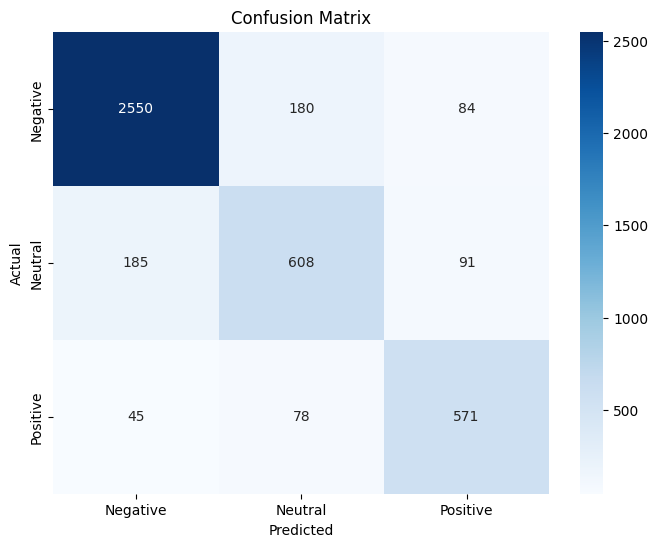

In [25]:
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

# Evaluate the model on the validation set
def evaluate_model(model, val_df):
    predictions = []
    actuals = val_df['target'].tolist()

    for text in val_df['text']:
        sentiment = predict(text)
        predictions.append({'negative': 0, 'neutral': 1, 'positive': 2}[sentiment.lower()])


    # Calculate metrics
    print("Classification Report:")
    print(classification_report(actuals, predictions, target_names=['Negative', 'Neutral', 'Positive']))

    # Confusion Matrix
    cm = confusion_matrix(actuals, predictions)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Negative', 'Neutral', 'Positive'], yticklabels=['Negative', 'Neutral', 'Positive'])
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.title('Confusion Matrix')
    plt.show()

# Run the evaluation
evaluate_model(model, val_df)


<ipython-input-35-d30d57bc2929>:16: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=sentiment_counts.index, y=sentiment_counts.values, palette=['red', 'green', 'blue'])


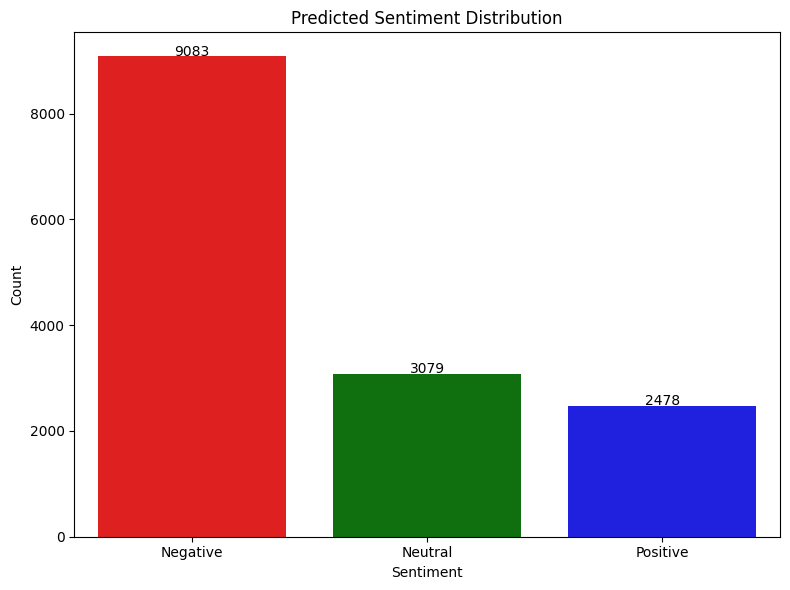

In [35]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Generate predictions using your predict function
df['predicted_sentiment'] = df['text'].apply(lambda x: predict(x))

# Count the predicted sentiments
sentiment_counts = df['predicted_sentiment'].value_counts()

# Ensure the sentiment categories appear in a specific order
sentiment_counts = sentiment_counts.reindex(['Negative', 'Neutral', 'Positive'])

# Plot the distribution using seaborn
plt.figure(figsize=(8, 6))
sns.barplot(x=sentiment_counts.index, y=sentiment_counts.values, palette=['red', 'green', 'blue'])
plt.title('Predicted Sentiment Distribution')
plt.xlabel('Sentiment')
plt.ylabel('Count')
plt.xticks(rotation=0)

# Add data labels on top of each bar
for index, value in enumerate(sentiment_counts):
    plt.text(index, value + 10, str(value), ha='center')

plt.tight_layout()
plt.show()
